In [1]:
!pip install folium
!pip install git+https://github.com/ulikoehler/UliEngineering.git

  Cloning https://github.com/ulikoehler/UliEngineering.git to /tmp/pip-req-build-dbnwe0t9
  Running command git clone -q https://github.com/ulikoehler/UliEngineering.git /tmp/pip-req-build-dbnwe0t9


In [2]:
# Import all
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pylab import rcParams

import folium
from folium import features

rcParams['figure.figsize'] = 14, 6

%matplotlib inline

### Load Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving lapan_hotspot_24_nov.csv to lapan_hotspot_24_nov.csv


In [3]:
# Read CSV File with Geographical data
data = pd.read_csv('lapan_hotspot_24_nov.csv', sep=",")
data.head()

,id,tanggal (WIB),waktu (WIB),lintang,bujur,tingkat kepercayaan,satelit,radius kemungkinan,kecamatan,kabupaten,provinsi,tipe
0,3561502,2021-11-24,12:34:00,-3.877416,122.399963,8,aqua,3000,Bondoala,Konawe,Sulawesi Tenggara,Cluster
1,3561501,2021-11-24,12:34:00,-4.287866,119.960716,8,aqua,3000,Ganra,Soppeng,Sulawesi Selatan,Cluster
2,3561503,2021-11-24,12:34:00,-2.787812,120.276352,8,aqua,3000,Malangke Barat,Luwu Utara,Sulawesi Selatan,Cluster
3,3561484,2021-11-24,00:18:56,-10.155959,124.327354,8,noaa20,1125,Amanuban Selatan,Timor Tengah Selatan,Nusa Tenggara Timur,Cluster
4,3561497,2021-11-24,11:17:32,-9.827483,124.752777,8,noaa20,1280,Amanatun Selatan,Timor Tengah Selatan,Nusa Tenggara Timur,Cluster


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   65 non-null     int64  
 1   tanggal (WIB)        65 non-null     object 
 2   waktu (WIB)          65 non-null     object 
 3   lintang              65 non-null     float64
 4   bujur                65 non-null     float64
 5   tingkat kepercayaan  65 non-null     int64  
 6   satelit              65 non-null     object 
 7   radius kemungkinan   65 non-null     int64  
 8   kecamatan            65 non-null     object 
 9   kabupaten            65 non-null     object 
 10  provinsi             65 non-null     object 
 11  tipe                 65 non-null     object 
dtypes: float64(2), int64(3), object(7)
memory usage: 6.2+ KB


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


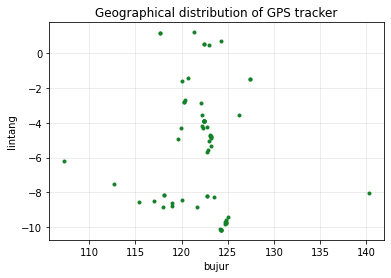

In [5]:
# Plot the geographical points
_ = plt.plot(data['bujur'], data['lintang'],
             marker='.', linewidth=0, color='#128128')
_ = plt.grid(which='major', color='#cccccc', alpha=0.45)
_ = plt.title('Geographical distribution of GPS tracker', family="Arial", fontsize=12)
_ = plt.xlabel('bujur')
_ = plt.ylabel('lintang')
_ = plt.show()

#### Step 3: Prepare DBSCAN model

In [6]:
# Prepare data for Model
dbscan_data = data[['bujur', 'lintang']]
dbscan_data = dbscan_data.values.astype('float32', copy=False)

In [7]:
dbscan_data_scalar = StandardScaler().fit(dbscan_data)
dbscan_data = dbscan_data_scalar.transform(dbscan_data)

In [8]:
# Construct model
'''
-- min_samples :: requires a minimum 20 data points in a neightborhood
-- eps :: in radius 0.02
'''

earth_radius_m = 19.36
epsilon = 5 / earth_radius_m
print(epsilon)

model = DBSCAN(eps = epsilon, min_samples=5, metric='euclidean').fit(dbscan_data)
model

0.2582644628099174


DBSCAN(eps=0.2582644628099174)

#### Adding label into original data frame

In [9]:
data['label_cluster'] = model.labels_

In [10]:
# Separate outliers from clustered data
outliers_df = data[model.labels_ == -1]
clusters_df = data[model.labels_ != -1]

colors = model.labels_
colors_clusters = colors[colors != -1]
color_outliers = 'black'

# Get info about the clusters
clusters = Counter(model.labels_)
print(clusters)
print(data[model.labels_ == -1].head())
print('Number of clusters = {}'.format(len(clusters)-1))

Counter({-1: 27, 0: 21, 1: 12, 2: 5})
        id tanggal (WIB)  ...     tipe  label_cluster
1  3561501    2021-11-24  ...  Cluster             -1
2  3561503    2021-11-24  ...  Cluster             -1
5  3561526    2021-11-24  ...  Cluster             -1
6  3561496    2021-11-24  ...  Cluster             -1
7  3561481    2021-11-24  ...  Cluster             -1

[5 rows x 13 columns]
Number of clusters = 3


<function matplotlib.pyplot.show>

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


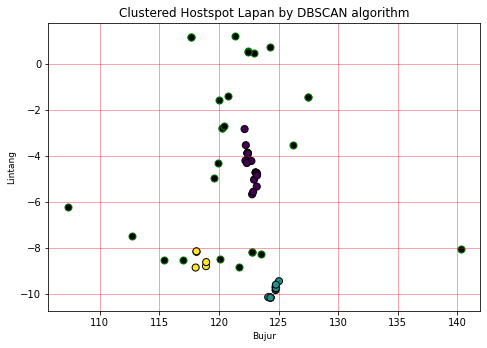

In [11]:
fig = plt.figure()

ax = fig.add_axes([.1, .1, 1, 1])

ax.scatter(clusters_df['bujur'], clusters_df['lintang'],
           c = colors_clusters, edgecolors='black', s=50)

ax.scatter(outliers_df['bujur'], outliers_df['lintang'],
           c = color_outliers, edgecolors='green', s=50)

ax.set_xlabel('Bujur', family='Arial', fontsize=9)
ax.set_ylabel('Lintang', family='Arial', fontsize=9)

plt.title('Clustered Hostspot Lapan by DBSCAN algorithm', family='Arial', fontsize=12)
plt.grid(which='major', color='#e30022', alpha=0.45)
plt.show

#### **Seperating cluster into it's own DataFrame with cluster_label**

In [12]:
num_cluster = clusters_df['label_cluster'].nunique()

In [13]:
## Separate each cluster to a DataFrame

cluster_no = []
for n in range(num_cluster):
 cluster = data.loc[(data['label_cluster']==n)]
 cluster_no.append(cluster)

#### **Getting Bounding box from each cluster**

In [21]:
from UliEngineering.Math.Coordinates import BoundingBox

def get_bbox_from_cluster(which_cluster):
  cluster_coord = which_cluster[['bujur', 'lintang']]
  coords = np.asarray(cluster_coord)
  list_coor = BoundingBox(coords)
  lonMin = list_coor.minx
  latMin = list_coor.miny
  lonMax = list_coor.maxx
  latMax = list_coor.maxy
  bbox = [(latMin, lonMin), (latMax, lonMax)]
  return bbox

In [30]:
## Getting bounding box coordinate from each cluster

bbox_each_cluster = []
for n_clus in cluster_no:
  bbox_cluster = get_bbox_from_cluster(n_clus)
  bbox_each_cluster.append(bbox_cluster)

In [31]:
bbox_each_cluster

[[(-5.66710091, 122.154506685), (-2.83345592, 123.20258331)],
 [(-10.159523010253906, 124.13288116), (-9.439041615, 125.035930635)],
 [(-8.848724365234375, 118.04803466796876), (-8.14128017, 118.93218231201172)]]

In [33]:
def color_label(label):
  if label == -1:
    color = "black"
  else:
    color = "red"
  
  return color

In [35]:
data['color'] = data['label_cluster'].apply(lambda row: color_label(row))

map_NM = folium.Map(location=[data['lintang'].mean(), data['bujur'].mean()],
               zoom_start=7,
               tiles='openstreetmap',
               control_scale=True)

for lat, lng, col in zip(data['lintang'],
                            data['bujur'],
                            data['color'],):
    # label = '{}'.format(col)
    #label = folium.Popup(label, parse_html=True)
    
    folium.CircleMarker([lat, lng],
    radius=5,
    color= col,
    fill=True,
    fill_color='#3186cc=',
    fill_opacity=0.7,
    parse_html=False).add_to(map_NM) 

for n_bbox in bbox_each_cluster:
  folium.Rectangle(n_bbox).add_to(map_NM)  


    
map_NM.save('mapping_cluster.html')